# Introduction

MedGemma is a multimodal specialized model from Google DeepMind. It is based on Gemma 3 model.

MedGemma comes in two variants:
* A 4B multimodal version (tex-image input and text output)  
* A 27B text-only version

MedGemma 4B uses an image encoder that was trained with a large variety of medical data (anonymized), that include X-Ray, dermatology images, MRI images, ophtalmology images, and histopathology digitized images.

Few resources available:
* Model on Google Cloud Model Garden: [MedGemma](https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/medgemma)
* Model on Hugging Face: [MedGemma](https://huggingface.co/collections/google/medgemma-release-680aade845f90bec6a3f60c4)
* GitHub repository (supporting code, Colab notebooks, discussions, and issues): [MedGemma](https://github.com/google-health/medgemma)

Important:
* MedGemma can be used in research and/or clinical decision support, not direct diagnosis.  
* It is trained with privacy and security in mind (HIPPA & GDPR-aligned practices).
* MedGemma is transparent about its limitations, biases, and potential misdiagnosis risks.




# Prerequisites

Gemma 3 is supported from transformers 4.50.0. If your Notebook is preinstalled with an earlier version, you will need to upgrage transformers library:

```python
pip install -U transformers
```

In [1]:
import os
import torch
import requests
from PIL import Image
from transformers import pipeline
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

2025-07-09 07:50:12.573798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752047412.822336      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752047412.893221      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load the model

We will load the model from HuggingFace, since at the time when this Notebook was written, the model is not yet published on Kaggle.  

The model is protected, therefore you will have to:
- Authenticate before accessing.
- Accept the terms and conditions to use it.

You have few alternatives to access the model. On Kaggle, it is most convenient to use a access token, generated from HuggingFace and stored as a secret using `kaggle_secrets`.

## Authenticate to access the model

In [2]:
user_secrets = UserSecretsClient()
hugging_face_token = user_secrets.get_secret("HUGGINGFACE_TOKEN")

After you load the secret, you can login using `huggingface_hub` `login` function and with the authentication token as parameter.

In [3]:

login(hugging_face_token)

## Define a model pipeline

Once authenticated, we can use `transformers` `pipeline` to initialize the model. In the pipeline initialization, we specify the mode **image-text-to-text**. We will load an image together with the user instructions and the model output will contain text only.

In [4]:
pipe = pipeline(
    "image-text-to-text",
    model="google/medgemma-4b-it",
    torch_dtype=torch.bfloat16,
    device="cuda",
)

config.json:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Device set to use cuda


# Load a medical image

We will initially test the model with the suggested (in HuggingFace documentation of the model) open source image from Wikipedia.

In [5]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/c/c8/Chest_Xray_PA_3-8-2010.png"
image = Image.open(requests.get(image_url, headers={"User-Agent": "example"}, stream=True).raw)

Let's show the image.

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c8/Chest_Xray_PA_3-8-2010.png" width=400></img>

# Query the model

We prepare the query, specifying the system prompt (using system role) and, using the user role, the instructions for the model as well as the image to interpret.

In [6]:
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are an expert radiologist."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Describe this X-ray"},
            {"type": "image", "image": image},
        ]
    }
]

We then run the query.

In [7]:
output = pipe(text=messages, max_new_tokens=256)

Let's show the text as markdown.

In [8]:
display(Markdown(output[0]["generated_text"][-1]["content"]))

Okay, here's a description of the chest X-ray you sent:

**Overall Impression:**

The chest X-ray shows a normal adult male. The lungs are clear, the heart size is within normal limits, and there are no obvious signs of acute pathology.

**Specific Findings:**

*   **Bones:** The ribs, clavicles, and scapulae appear intact and without fractures. The vertebral bodies are also intact.
*   **Heart:** The heart size is within normal limits. The cardiothoracic ratio (the width of the heart compared to the width of the chest) is also within normal limits.
*   **Lungs:** The lungs are clear bilaterally. There is no evidence of consolidation, effusion, or pneumothorax. The pulmonary vasculature appears normal.
*   **Mediastinum:** The mediastinum (the space between the lungs containing the heart, great vessels, trachea, and esophagus) is unremarkable.
*   **Diaphragm:** The diaphragms are well-defined and located at the normal level.
*   **Soft Tissues:** There are no obvious masses or abnormalities in the soft tissues of the chest wall.

**In summary, this is a normal chest X-ray.**



We demonstrated how to load the model, initialize the pipeline, run the pipeline with image and text instructions and also display the output.
We will test now the model with different types of medical images.

# Interpret malignant image from a Kaggle dataset

We load now an image from a Kaggle dataset with skin melanoma cases. The dataset is: [Melanoma Skin Cancer Dataset of 10000 Images](https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images).

In [9]:
image_path = "/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train/malignant/melanoma_5003.jpg"
image = Image.open(image_path)

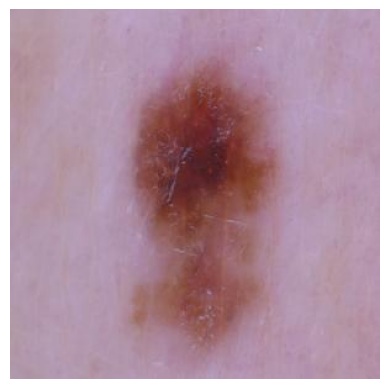

In [10]:

plt.imshow(image)
plt.axis('off') 
plt.show()

In [11]:
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are an expert radiologist."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Analyze this image."},
            {"type": "image", "image": image},
        ]
    }
]

In [12]:
output = pipe(text=messages, max_new_tokens=256)

In [13]:
display(Markdown(output[0]["generated_text"][-1]["content"]))

Based on the image provided, here's a radiologist's analysis:

**Findings:**

*   **Macular Hyperpigmentation:** The image shows a well-defined, roundish, and slightly irregular lesion with a darker central area. This is consistent with a macular hyperpigmentation.

**Differential Diagnosis:**

Given the appearance, the differential diagnosis includes:

*   **Solar Lentigines (Sun Spots):** These are common, benign, and often appear as flat, brown spots on sun-exposed areas.
*   **Melanocytic Nevi (Moles):** These are common, benign skin growths that can vary in color and size.
*   **Dermal Melanocytosis:** This is a less common type of mole that can be more deeply pigmented and may have a slightly different appearance.
*   **Other Pigmented Lesions:** Other less common pigmented lesions could also present similarly.

**Recommendations:**

*   **Clinical Correlation:** It is essential to correlate these findings with the patient's clinical history, including sun exposure, personal and family history of skin cancer, and any other relevant medical information.
*   **Dermoscopy:** Dermoscopy (using a handheld device to examine the skin lesion in more

Let's check another image.

In [14]:
image_path = "/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train/malignant/melanoma_5009.jpg"
image = Image.open(image_path)

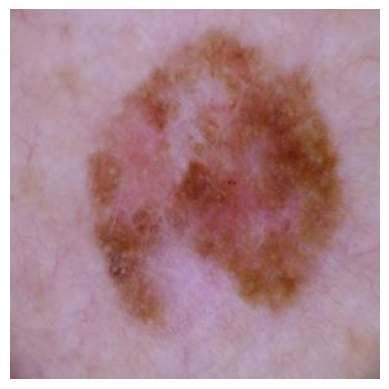

In [15]:
plt.imshow(image)
plt.axis('off') 
plt.show()

In [16]:
output = pipe(text=messages, max_new_tokens=256)
display(Markdown(output[0]["generated_text"][-1]["content"]))

Based on the image provided, here's a radiologist's analysis:

**Findings:**

*   **Macular Hyperpigmentation:** The image shows a well-defined, roundish, and slightly irregular lesion with a darker central area. This is consistent with a macular hyperpigmentation.

**Differential Diagnosis:**

Given the appearance, the differential diagnosis includes:

*   **Solar Lentigines (Sun Spots):** These are common, benign, and often appear as flat, brown spots on sun-exposed areas.
*   **Melanocytic Nevi (Moles):** These are common, benign skin growths that can vary in color and size.
*   **Dermal Melanocytosis:** This is a less common type of mole that can be more deeply pigmented and may have a slightly different appearance.
*   **Other Pigmented Lesions:** Other less common pigmented lesions could also present similarly.

**Recommendations:**

*   **Clinical Correlation:** It is essential to correlate these findings with the patient's clinical history, including sun exposure, personal and family history of skin cancer, and any other relevant medical information.
*   **Dermoscopy:** Dermoscopy (using a handheld device to examine the skin lesion in more

# COVID induced pneumonia

Let's also analyse some COVID induced pneumonia images. We will use images from the dataset: [COVID-19 Xray Dataset (Train & Test Sets)](https://www.kaggle.com/datasets/khoongweihao/covid19-xray-dataset-train-test-sets)

In [17]:
image_path = "/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train/PNEUMONIA/7EF28E12-F628-4BEC-A8C5-E6277C2E4F60.png"
image = Image.open(image_path)

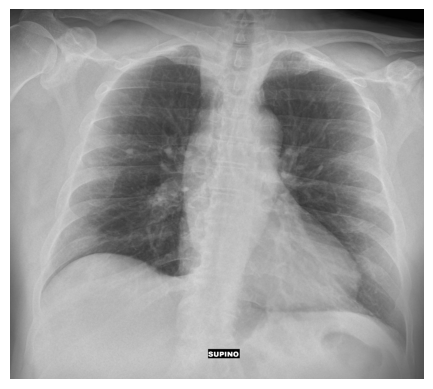

In [18]:
plt.imshow(image)
plt.axis('off') 
plt.show()

In [19]:
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are an expert radiologist."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Analyze this X-Ray image to identify signs of pneumonia."},
            {"type": "image", "image": image},
        ]
    }
]

In [20]:
output = pipe(text=messages, max_new_tokens=256)

In [21]:
display(Markdown(output[0]["generated_text"][-1]["content"]))

Okay, I've reviewed the chest X-ray. Here's my analysis, keeping in mind that I am an AI and cannot provide a definitive diagnosis without clinical context and potentially additional imaging:

**Overall Impression:**

The image shows a supine chest X-ray. The heart size appears to be within normal limits. The mediastinum is unremarkable. The lung fields are relatively clear, but there are some findings that warrant further investigation.

**Potential Findings Suggestive of Pneumonia (though not definitive):**

*   **Increased Opacity in the Right Lower Lobe:** There is a subtle area of increased density in the right lower lobe. This could represent consolidation, which is a hallmark of pneumonia. However, it could also be due to other causes such as atelectasis, pleural effusion, or a mass.

**Other Considerations:**

*   **Patient Positioning:** The supine position can sometimes obscure subtle findings.
*   **Clinical History:** The patient's symptoms (cough, fever, shortness of breath, etc.) are crucial for interpreting the X-ray.

**Recommendations:**

Based on this single image, I would recommend the following:

1.  **Clinical Correlation:** The X-ray findings should be correlated with

# Ophtalmology images

We are looking next to selections from a [Diabetic Retinopathy (resized) dataset](https://www.kaggle.com/datasets/tanlikesmath/diabetic-retinopathy-resized).

In [22]:
image_path = "/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/10009_right.jpeg"
image = Image.open(image_path)

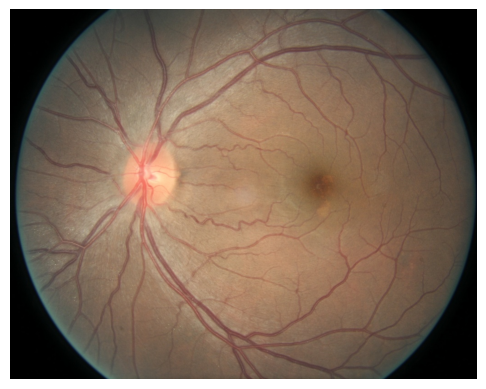

In [23]:
plt.imshow(image)
plt.axis('off') 
plt.show()

In [24]:
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are an expert radiologist."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Analyze this image, identify the modality and suggest diagnosis."},
            {"type": "image", "image": image},
        ]
    }
]

In [25]:
output = pipe(text=messages, max_new_tokens=300)

In [26]:
display(Markdown(output[0]["generated_text"][-1]["content"]))

Based on the image provided, the modality is **fundus photography**.

The image shows a fundus view of the eye. The optic disc, retinal vessels, and macula are visible.

Without further clinical information, it is impossible to provide a definitive diagnosis. However, fundus photography is a common diagnostic tool used to evaluate various eye conditions, including:

*   **Diabetic retinopathy:** Assessing for microaneurysms, hemorrhages, exudates, and neovascularization.
*   **Hypertensive retinopathy:** Identifying signs of damage to the retinal blood vessels.
*   **Age-related macular degeneration (AMD):** Evaluating for drusen, pigmentary changes, and neovascularization.
*   **Retinal detachment:** Detecting a detached retina.
*   **Optic disc abnormalities:** Assessing for optic nerve swelling, pallor, or other lesions.
*   **Vitreous hemorrhage:** Identifying blood in the vitreous cavity.

To provide a more specific diagnosis, additional clinical information is needed, such as the patient's history, symptoms, and any other relevant findings.


# Brain MRI scans

We are looking next to selections from a [Brain Tumor MRI dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

In [27]:
image_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0012.jpg"
image = Image.open(image_path)

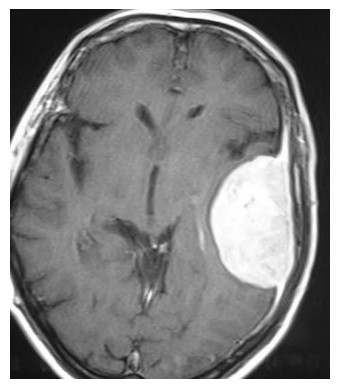

In [28]:
plt.imshow(image)
plt.axis('off') 
plt.show()

In [29]:
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are an expert radiologist."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Analyze this image, identify the modality and suggest diagnosis."},
            {"type": "image", "image": image},
        ]
    }
]

In [30]:
output = pipe(text=messages, max_new_tokens=300)

In [31]:
display(Markdown(output[0]["generated_text"][-1]["content"]))

Based on the image provided, the modality is **Magnetic Resonance Imaging (MRI)**.

The diagnosis is most likely a **large, enhancing mass in the left temporal lobe**.

Here's a breakdown of the findings:

*   **Location:** The mass appears to be located in the left temporal lobe, which is evident from the anatomical landmarks visible.
*   **Appearance:** The mass is characterized by a large, fluid-filled area with a bright signal intensity on T2-weighted images (as seen in the image). This suggests a cystic or fluid-filled component.
*   **Enhancement:** The mass shows significant enhancement with contrast, indicating increased blood flow to the area. This is a common feature of many types of brain tumors.
*   **Surrounding Tissue:** The surrounding brain tissue appears relatively normal, although there may be some edema (swelling) around the mass.

**Possible Differential Diagnoses:**

Given the appearance, some possible differential diagnoses include:

*   **Brain Abscess:** A collection of pus within the brain parenchyma.
*   **Cerebral Cyst:** A fluid-filled sac within the brain.
*   **Tumor:** A variety of primary or metastatic brain tumors could present with these characteristics.
*   **Epidermoid Cyst:** A benign, slow-growing tumor that can contain keratin.

**Further Evaluation:**

To confirm the diagnosis and determine the specific type of lesion, further evaluation is necessary

# Histopathology images

We will inspect as well breast histopathology images from the dataset [BreaKHis 400X](https://www.kaggle.com/datasets/forderation/breakhis-400x).

In [32]:
image_path = "/kaggle/input/breakhis-400x/BreaKHis 400X/train/malignant/SOB_M_DC-14-11031-400-009.png"
image = Image.open(image_path)

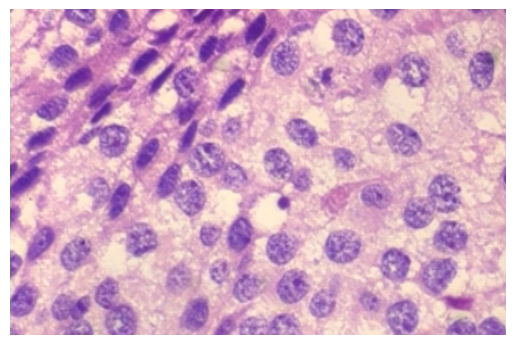

In [33]:
plt.imshow(image)
plt.axis('off') 
plt.show()

In [34]:
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are an expert radiologist."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Analyze this image, identify the modality and suggest diagnosis."},
            {"type": "image", "image": image},
        ]
    }
]

In [35]:
output = pipe(text=messages, max_new_tokens=300)
display(Markdown(output[0]["generated_text"][-1]["content"]))

Based on the image provided, the modality is **histopathology**.

The image shows a microscopic view of tissue, likely from a biopsy. The cells are small, round, and have a high nuclear-to-cytoplasmic ratio. This morphology is highly suggestive of **carcinoma**, specifically a **small cell carcinoma**.

Here's a breakdown of why:

*   **Small, round cells:** This is a hallmark of small cell carcinoma.
*   **High nuclear-to-cytoplasmic ratio:** The nuclei are large and prominent compared to the cytoplasm, which is typical of small cell carcinoma.
*   **Lack of distinct cell borders:** The cells appear somewhat irregular and lack well-defined borders.
*   **Presence of nuclear molding:** The cells appear to be molding to each other, which is also characteristic of small cell carcinoma.

**Important Considerations:**

*   This is a preliminary interpretation based on a single microscopic image. A definitive diagnosis requires a full pathology report, including immunohistochemical stains and clinical correlation.
*   Other types of carcinomas, such as neuroendocrine tumors, can also present with similar morphology.
*   The specific subtype of small cell carcinoma (e.g., squamous cell, adenocarcinoma) would require further investigation.

**In summary, the image is highly suggestive of small cell carcinoma, but a definitive diagnosis requires further investigation.**


Let's check a second image.

In [36]:
image_path = "/kaggle/input/breakhis-400x/BreaKHis 400X/train/malignant/SOB_M_DC-14-11520-400-005.png"
image = Image.open(image_path)

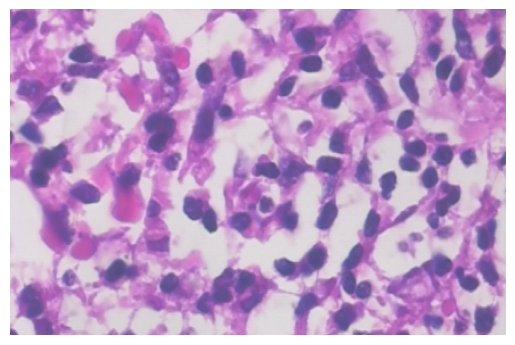

In [37]:
plt.imshow(image)
plt.axis('off') 
plt.show()

In [38]:
output = pipe(text=messages, max_new_tokens=300)
display(Markdown(output[0]["generated_text"][-1]["content"]))

Based on the image provided, the modality is **histopathology**.

The image shows a microscopic view of tissue, likely from a biopsy. The cells are small, round, and have a high nuclear-to-cytoplasmic ratio. This morphology is highly suggestive of **carcinoma**, specifically a **small cell carcinoma**.

Here's a breakdown of why:

*   **Small, round cells:** This is a hallmark of small cell carcinoma.
*   **High nuclear-to-cytoplasmic ratio:** The nuclei are large and prominent compared to the cytoplasm, which is typical of small cell carcinoma.
*   **Lack of distinct cell borders:** The cells appear somewhat irregular and lack well-defined borders.
*   **Presence of nuclear molding:** The cells appear to be molding to each other, which is also characteristic of small cell carcinoma.

**Important Considerations:**

*   This is a preliminary interpretation based on a single microscopic image. A definitive diagnosis requires a full pathology report, including immunohistochemical stains and clinical correlation.
*   Other types of carcinomas, such as neuroendocrine tumors, can also present with similar morphology.
*   The specific subtype of small cell carcinoma (e.g., squamous cell, adenocarcinoma) would require further investigation.

**In summary, the image is highly suggestive of small cell carcinoma, but a definitive diagnosis requires further investigation.**


# More resources

I created a project on GitHub with a small application based on MedGemma:
- MedGemma from Google Model Garden deployed using VertexAI in GCP
- Backend & UI with Streamlit deployed on GCP using App Engine
Link to project: [med-sight](https://github.com/gabrielpreda/med-sight)

I documented it in an medium article, here: [MedSight: Interpreting Medical Images with MedGemma](https://medium.com/@gabi.preda/medsight-interpreting-medical-images-with-medgemma-29f9e755bcc9)

Note: this is part of the **AI Sprint** initiative.

# Conclusions


This specialized model from Google DeepMind allows interpretation of a variety of medical images.   
We looked to X-Ray images for chest, MRI scan slices for brain, skin melanoma images, and breast cancer hystopathology images.

While the amount of details and specificity of medical comments is impressive, the model is also providing clear information that its output it is not to be used as a definitive medical diagnosys.


These are possible medical applications for MedGemma:

* Diagnostic Assistance:
    * Radiology (X-rays, MRI): Differential diagnosis from images + clinical notes.
    * Dermatology: Skin lesion classification and triage support.
    * Ophthalmology: Retinal image analysis (e.g., diabetic retinopathy).* 
    * Histopathology: Interpretation of digitized tissue slides.
  

* Clinical Decision Support:
    * Symptom analysis and diagnostic suggestions.
    * Triage support in emergency or outpatient settings.


* Medical Research:
    * Literature summarization, question answering from research papers.
    * Hypothesis generation from clinical data or case reports.



